In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def calculate_historical_imbalance(df, window=100, lookback_periods=10, threshold_std=1.0, col='volume'):
    """
    实时可用的不平衡因子 - 使用历史数据代替未来数据
    
    参数:
    df: 包含OHLCV数据的DataFrame
    window: 滚动窗口大小(默认100)
    lookback_periods: 历史回顾周期(默认10)
    threshold_std: 异常阈值倍数(默认1.0)
    col: 分析的目标列(默认volume)
    """
    # 复制数据避免修改原始数据
    df = df.copy()
    
    # 计算周期收益率 (close - open)/open
    df['period_return'] = (df['close'] - df['open']) / df['open']
    
    # 创建历史收益率矩阵
    hist_returns = df['period_return'].shift(1)  # 避免包含当前点
    
    returns_matrix = pd.DataFrame()
    for i in range(1, lookback_periods + 1):
        returns_matrix[f't-{i}'] = hist_returns.shift(i - 1)
    
    # 计算历史不平衡值
    def calc_imbalance(row):
        # 分离正负收益
        pos_returns = row[row > 0]
        neg_returns = row[row < 0]
        
        # 计算平均正负收益
        avg_pos = pos_returns.mean() if len(pos_returns) > 0 else 0
        avg_neg = abs(neg_returns.mean()) if len(neg_returns) > 0 else 0
        
        # 计算不平衡值
        return avg_pos - avg_neg
    
    # 应用计算历史不平衡值
    df['hist_imbalance'] = returns_matrix.apply(calc_imbalance, axis=1)
    
    # 计算成交量均值和标准差（滚动窗口）
    df['volume_mean'] = df[col].rolling(window=window, min_periods=10).mean()
    df['volume_std'] = df[col].rolling(window=window, min_periods=10).std().replace(0, 1e-6)
    
    # 识别异常点
    df['is_abnormal'] = (df[col] > (df['volume_mean'] + threshold_std * df['volume_std'])).astype(int)
    
    # 组合因子值 = 异常信号 × 历史不平衡值
    factor_values = df['is_abnormal'] * df['hist_imbalance']
    
    # 标准化因子值
    scaler = StandardScaler()
    factor_values = pd.Series(
        scaler.fit_transform(factor_values.values.reshape(-1, 1)).flatten(),
        index=df.index
    )
    
    return factor_values

# 创建因子计算函数
def historical_imbalance_factor(df):
    return calculate_historical_imbalance(df)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.002994
   Rank_IC (Spearman): -0.014130
📊 信息比率:
   IR: 0.554450
   有效分组数: 2
📊 因子分布:
📋 数据概况:
   数据长度: 131035
   因子列: historical_imbalance
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


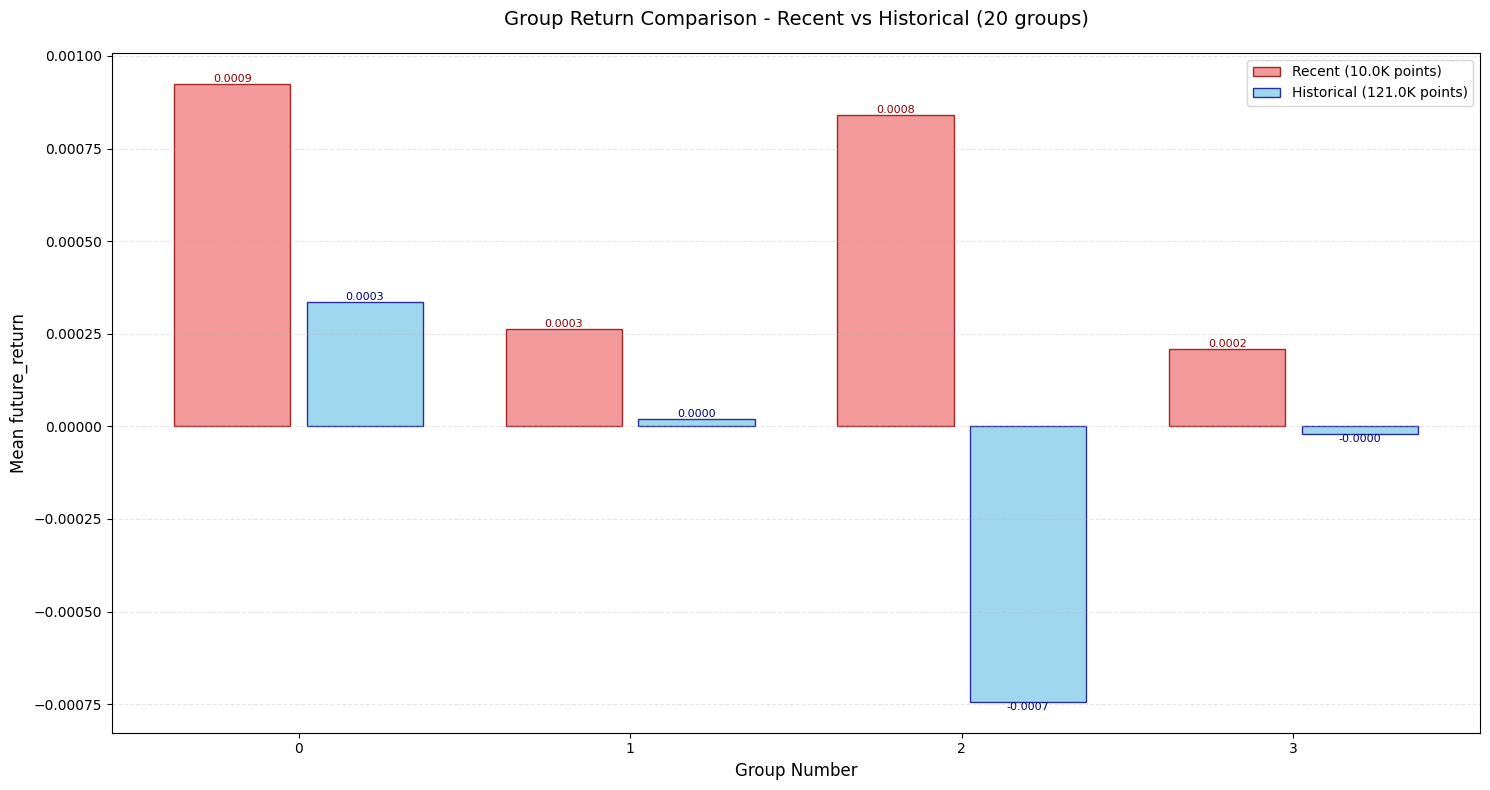

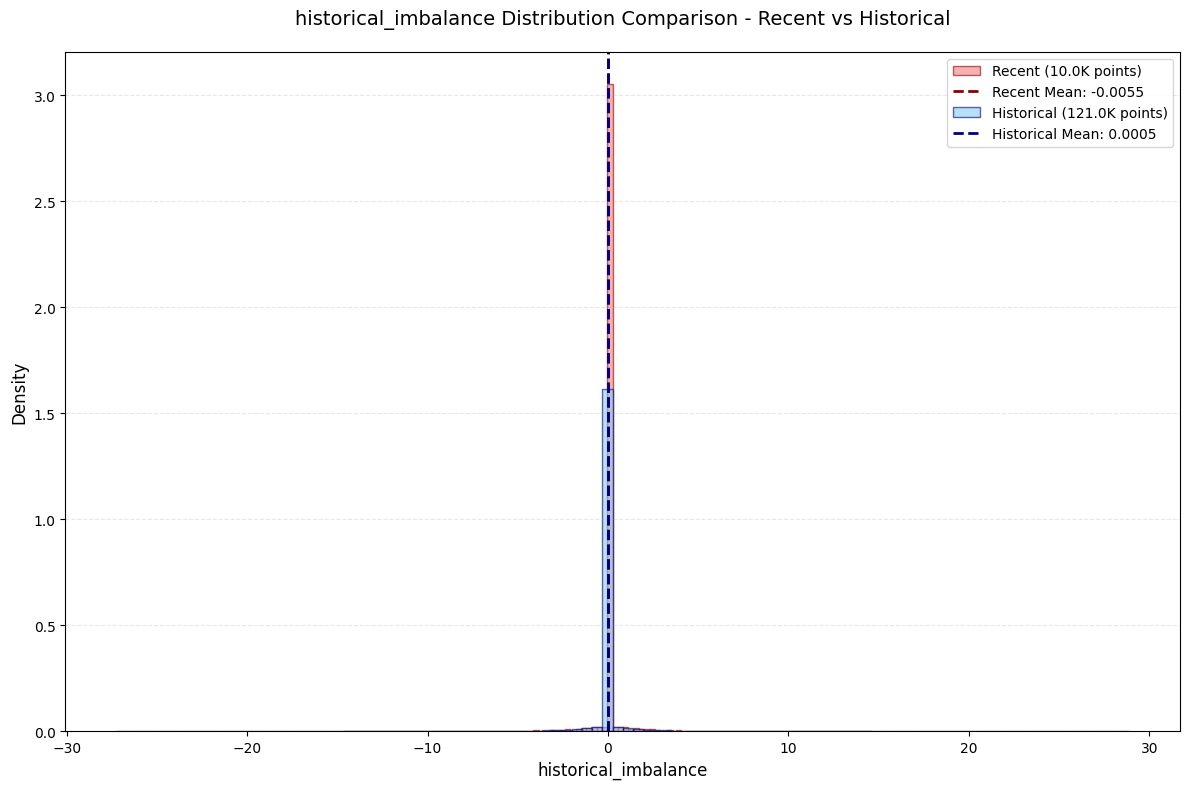

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=historical_imbalance_factor,
    factor_name='historical_imbalance'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

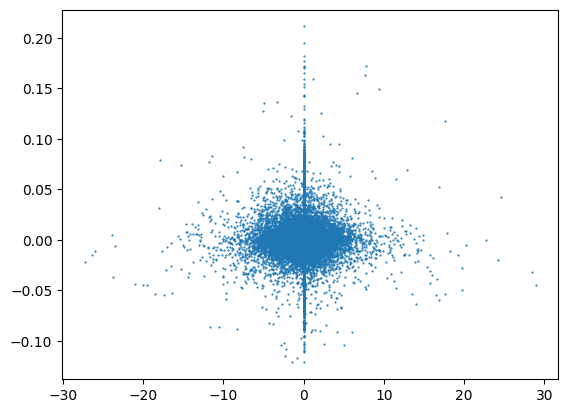

In [6]:
import matplotlib.pyplot as plt
plt.scatter(calculate_historical_imbalance(df),df['close'].pct_change(-10), s=0.3)

In [7]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.012535782999454091, 0.04373532825104843]

In [8]:
print(result)

{'correlation_analysis': {'IC': -0.002994037740374224, 'Rank_IC': -0.014129845811809628}, 'information_ratio': {'IR': 0.5544504908158485, 'group_correlations': [-0.012535782999454091, 0.04373532825104843], 'n_groups': 2}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std   count
group                                                             
0     -27.2678  -0.2153   -2.3403       0.0004      0.0158    6552
1      -0.2152   0.0184    0.0176       0.0000      0.0112  117529
2       0.0188   0.1391    0.0797      -0.0006      0.0136     402
3       0.1391  28.8945    2.0203       0.0000      0.0153    6552, 'figure': <Figure size 1500x800 with 1 Axes>}, 'factor_distribution': {'descriptive_stats': count   131035.0000
mean        -0.0000
std          1.0000
min        -27.2678
1%          -3.5373
5%          -0.2152
25%          0.0184
50%          0.0184
75%          0.0184
95%          0.1391
99%          3.0177
max         28.8945
Name: his